## 利用tensorflow 构建模型

### 案例介绍以及需要导入的类

tensorflow 构建模型其实很简单：两个大步骤
- 构建计算图
- 运行计算图

下面来介绍以下该案例：

构建一个神经网络模型来实现对手势的识别，需要识别如下图所示的几种手势类型：
![](imgs/5.jpg)

- 训练数据1080张，(64x64),代表了从0-5，每个数字有180张
- 测试数据120张,(64x64)


需要导入如下库：

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [5]:
# 导入数据

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

#对数据做预处理
# Flatten 数据拉伸成一列
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# 像素归一化
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

#将标签数据转换成one_hot的形式
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

y = 5


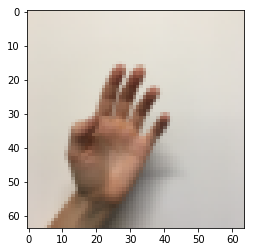

In [4]:
# 显示一张图片
index =15
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [6]:
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


通过上面的数据预处理，我们得到想要作为模型输入的数据格式，下面我们来考虑以下，接下来需要建立模型的步骤：

- 创建输入占位符
- 初始化参数
- 创建前向传播，模型的结构
- 计算损失函数
- 选择优化方法进行反向传播获得梯度值，

### 创建输入占位符

这个时候我门需要考虑的是占位符的shape问题，这里我们能够确定的是，输入数据的特征的尺度，但是不知道每次需要输入多少个，这里需要使用placeholder 中的None来代替。具体过程如下：

In [7]:
def create_placeholders(n_x,n_y):
    """
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    """
    
    X = tf.placeholder(tf.float32,shape=[n_x,None])
    Y = tf.placeholder(tf.float32,shape=[n_y,None])
    
    return X,Y

In [8]:
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)


### 初始化参数

这里参数的初始化，我们可以根据之前介绍，
- 利用Xavier的方法来初始化权重参数
    - tf.contrib.layers.xavier_initializer()
- 利用Zero来初始化偏置值

具体如下coding

In [10]:
def initialize_parameters():
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
   
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3",[6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters

In [11]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


### 前向传播

使用tf来完成前向传播需要用到的tf的函数如下：

- tf.add()
- tf.matmul()
- tf.nn.relu()

这里其实跟numpy实践很像，但是这有一个注意点就是，这里我们只需要计算到`z3`，因为上一小节我们知道，tf的损失函数会将a3的计算融入其中。

还有一点不同的就是我们发现在该函数我们并没有使用任何的缓存值，而是返回最后的值。继续往下看吧。


In [13]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3


In [14]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


### 损失函数

这里我们需要调用的是;
- tf.nn.softmax_cross_entropy_with_logits(logits,labels)
    - logits : Z3,因为上面的函数会自动计算A3的值。具体看上一小节
    - labels: Y
- tf.reduce_mean 
    - reduce_xxx:表示对张量进行降维，具体沿着那个方向降维呢，这里就需要根据axis的值来定。
        - axis = 0 :按列降维
        - axis = 1 :按行降维
    - reduce_mean:求平均值
    - reduce_sum:求和
    - reduce_min/max:求最大最小值
    
 具体的coding如下：

In [16]:
def comput_cost(Z3,Y):
    
    """
    参数：
        Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
        Y -- "true" labels vector placeholder, same shape as Z3
   """
    
    # 将数据转置，符合函数输入的模型
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits = logits,
        labels = labels
    ))
    
    tf.train.AdadeltaOptimizer
    return cost
    

### 反向传播以及参数更新

这里才是使用深度学习框架最为迷人的部分，也是最有价值的部分，因为它只需要少量的代码，就可以自动帮我们实现。

我们在这里通常称其为选择优化器- "optimizer"
- tf.train.GradientDescentOptimizer
- tf.train.AdamOptimizer
- tf.train.AdadeltaOptimizer
- ....

这里我们需要注意的一点是，选择好了优器后，我们需要将cost函数传递给该优化器。
在训练的时候，只需要run optimizer和cost

`_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})`

这里有一个有意思的符合`_`：表示存储的值我们将不会再使用。


In [ ]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

### 创建模型

好了，万事具备只欠东风了。


In [1]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    # 重置模型
    ops.reset_default_graph() 
    tf.set_random_seed(1) 
    seed = 3
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0] 
    costs = [] 
    
    X,Y = create_placeholders(n_x,n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X,parameters)
    
    cost = comput_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters
                

        
        
    